# Prediction & Corelation between SST and NPP Data

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np


In [ ]:
!pip install copernicusmarine

# Step 1: Install the Copernicus Marine Toolbox
import copernicusmarine

# Step 2: Login with Your Copernicus Marine Credentials
copernicusmarine.login(username="samikshakhare22@gmail.com", password="Counter@1")


File /root/.copernicusmarine/.copernicusmarine-credentials already exists, overwrite it ? [y/N]: y


INFO - 2025-05-01T17:10:15Z - Credentials file stored in /root/.copernicusmarine/.copernicusmarine-credentials.
INFO:copernicusmarine:Credentials file stored in /root/.copernicusmarine/.copernicusmarine-credentials.


True

# Data Extraction



### To cover Barbados and its nearby coastal waters (especially beaches) for analyzing Sea Surface Temperature (SST) and Net Primary Productivity (NPP), a safe and effective geographic bounding box

In [ ]:
# Get SST data: https://data.marine.copernicus.eu/product/SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001/download

copernicusmarine.subset(
   dataset_id = "METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2",
   variables = ["analysed_sst"],
   start_datetime = "2011-01-01T00:00:00",
   end_datetime = "2024-12-31T23:59:59",
   minimum_longitude = -59.7,
   maximum_longitude = -59.3,
   minimum_latitude = 12.95,
   maximum_latitude = 13.3,
   maximum_depth = 2,
   output_filename = "sst_data.nc",
   output_directory = "copernicus-data"
)

INFO - 2025-05-01T18:38:34Z - Selected dataset version: "default"
INFO:copernicusmarine:Selected dataset version: "default"
INFO - 2025-05-01T18:38:34Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
INFO - 2025-05-01T18:38:44Z - Starting download. Please wait...
INFO:copernicusmarine:Starting download. Please wait...


  0%|          | 0/10 [00:00<?, ?it/s]

INFO - 2025-05-01T18:38:50Z - Successfully downloaded to copernicus-data/sst_data.nc
INFO:copernicusmarine:Successfully downloaded to copernicus-data/sst_data.nc


ResponseSubset(file_path=PosixPath('copernicus-data/sst_data.nc'), output_directory=PosixPath('copernicus-data'), filename='sst_data.nc', file_size=0.5595343511450381, data_transfer_size=48.659541984732826, variables=['analysed_sst'], coordinates_extent=[GeographicalExtent(minimum=-59.67499923706055, maximum=-59.32500076293945, unit='degrees_east', coordinate_id='longitude'), GeographicalExtent(minimum=12.975000381469727, maximum=13.274999618530273, unit='degrees_north', coordinate_id='latitude'), TimeExtent(minimum='2011-01-01T00:00:00+00:00', maximum='2024-12-31T00:00:00+00:00', unit='iso8601', coordinate_id='time')], status='000', message='The request was successful.', file_status='DOWNLOADED')

In [ ]:
# Get NPP Data:  https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_BGC_001_033/description

copernicusmarine.subset(
   dataset_id="cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i",
   variables = [
    "net_primary_productivity_of_biomass_expressed_as_carbon_in_sea_water",
    "euphotic_zone_depth",
    "mass_content_of_zooplankton_expressed_as_carbon_in_sea_water"
],
   start_datetime = "2011-01-01T00:00:00",
   end_datetime = "2024-12-31T23:59:59",
   minimum_longitude = -59.7,
   maximum_longitude = -59.3,
   minimum_latitude = 12.95,
   maximum_latitude = 13.3,
   maximum_depth = 2,
   output_filename = "npp_data.nc",
   output_directory = "copernicus-data"
)


INFO - 2025-05-01T22:05:17Z - Selected dataset version: "202411"
INFO:copernicusmarine:Selected dataset version: "202411"
INFO - 2025-05-01T22:05:17Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
WARNING - 2025-05-01T22:05:28Z - Some of your subset selection [2011-01-01 00:00:00+00:00, 2024-12-31 23:59:59+00:00] for the time dimension exceed the dataset coordinates [1998-01-01 00:00:00+00:00, 2023-12-31 00:00:00+00:00]
INFO - 2025-05-01T22:05:33Z - Starting download. Please wait...
INFO:copernicusmarine:Starting download. Please wait...


  0%|          | 0/18 [00:00<?, ?it/s]

INFO - 2025-05-01T22:05:40Z - Successfully downloaded to copernicus-data/npp_data.nc
INFO:copernicusmarine:Successfully downloaded to copernicus-data/npp_data.nc


ResponseSubset(file_path=PosixPath('copernicus-data/npp_data.nc'), output_directory=PosixPath('copernicus-data'), filename='npp_data.nc', file_size=0.5566641221374046, data_transfer_size=89.06454961832061, variables=['npp', 'zeu', 'zooc'], coordinates_extent=[GeographicalExtent(minimum=-59.66666793823242, maximum=-59.33333206176758, unit='degrees_east', coordinate_id='longitude'), GeographicalExtent(minimum=12.999999046325684, maximum=13.249999046325684, unit='degrees_north', coordinate_id='latitude'), TimeExtent(minimum='2011-01-01T00:00:00+00:00', maximum='2023-12-31T00:00:00+00:00', unit='iso8601', coordinate_id='time')], status='000', message='The request was successful.', file_status='DOWNLOADED')

## Data Exploration

In [ ]:
import xarray as xr

# Open the NetCDF file
sst_ds = xr.open_dataset('/content/copernicus-data/sst_data.nc')
npp_ds = xr.open_dataset('/content/copernicus-data/npp_data.nc')

In [ ]:
# Rename using Dataset.rename
sst_ds = sst_ds.rename({'analysed_sst': 'sst'})
print(sst_ds.data_vars)

Data variables:
    sst      (time, latitude, longitude) float64 2MB ...


In [ ]:
# Renamed variable name from dataset
npp_var = npp_ds[['npp', 'zeu','zooc']]

# List all variables in the dataset
print(npp_var.data_vars)

Data variables:
    npp      (time, latitude, longitude) float64 760kB ...
    zeu      (time, latitude, longitude) float64 760kB ...
    zooc     (time, latitude, longitude) float64 760kB ...


In [ ]:
# Convert to DataFrame
npp_df = npp_var.to_dataframe().reset_index()
sst_df = sst_ds['sst'].to_dataframe().reset_index()

In [ ]:
sst_df.head()

,time,latitude,longitude,sst
0,2011-01-01,12.975,-59.674999,300.899993
1,2011-01-01,12.975,-59.625000,300.899993
2,2011-01-01,12.975,-59.575001,300.889993
3,2011-01-01,12.975,-59.525002,300.889993
4,2011-01-01,12.975,-59.474998,300.869993


In [ ]:
npp_df.head()

,time,latitude,longitude,npp,zeu,zooc
0,2011-01-01,12.999999,-59.666668,187.023839,85.819644,0.100170
1,2011-01-01,12.999999,-59.583332,194.926255,84.338955,0.088787
2,2011-01-01,12.999999,-59.500000,202.110269,82.889210,0.100170
3,2011-01-01,12.999999,-59.416668,204.026006,82.530255,0.104723
4,2011-01-01,12.999999,-59.333332,200.912933,83.070235,0.118383


## Handle missing values

In [ ]:
sst_df.shape

(286384, 4)

In [ ]:
sst_df.isnull().sum()

,0
time,0
latitude,0
longitude,0
sst,46026


In [ ]:
# Drop missing values
sst_df = sst_df.dropna()
sst_df.shape

(240358, 4)

In [ ]:
npp_df.isnull().sum()

,0
time,0
latitude,0
longitude,0
npp,9496
zeu,9496
zooc,9496


In [ ]:
npp_df.shape

(94960, 6)

In [ ]:
# Drop missing values
npp_df = npp_df.dropna()
npp_df.shape

(85464, 6)

## Merge SST and NPP datasets

In [ ]:
def truncate_one_decimal(x):
    return float(str(x)[:str(x).find('.') + 2])

sst_df['latitude'] = sst_df['latitude'].apply(truncate_one_decimal)
sst_df['longitude'] = sst_df['longitude'].apply(truncate_one_decimal)
sst_df.head()

,time,latitude,longitude,sst
0,2011-01-01,12.9,-59.6,300.899993
1,2011-01-01,12.9,-59.6,300.899993
2,2011-01-01,12.9,-59.5,300.889993
3,2011-01-01,12.9,-59.5,300.889993
4,2011-01-01,12.9,-59.4,300.869993


In [ ]:
def truncate_one_decimal(x):
    return float(str(x)[:str(x).find('.') + 2])

npp_df['latitude'] = npp_df['latitude'].apply(truncate_one_decimal)
npp_df['longitude'] = npp_df['longitude'].apply(truncate_one_decimal)

In [ ]:
npp_df.head()

,time,latitude,longitude,npp,zeu,zooc
0,2011-01-01,12.9,-59.6,187.023839,85.819644,0.100170
1,2011-01-01,12.9,-59.5,194.926255,84.338955,0.088787
2,2011-01-01,12.9,-59.5,202.110269,82.889210,0.100170
3,2011-01-01,12.9,-59.4,204.026006,82.530255,0.104723
4,2011-01-01,12.9,-59.3,200.912933,83.070235,0.118383


In [ ]:
merged_df = pd.merge(
    sst_df,
    npp_df,
    on=['time', 'latitude', 'longitude'],
    how='inner'
)


In [ ]:
print(merged_df.head())
print(merged_df.shape)


        time  latitude  longitude         sst         npp        zeu      zooc
0 2011-01-01      12.9      -59.6  300.899993  187.023839  85.819644  0.100170
1 2011-01-01      12.9      -59.6  300.899993  187.023839  85.819644  0.100170
2 2011-01-01      12.9      -59.5  300.889993  194.926255  84.338955  0.088787
3 2011-01-01      12.9      -59.5  300.889993  202.110269  82.889210  0.100170
4 2011-01-01      12.9      -59.5  300.889993  194.926255  84.338955  0.088787
(246896, 7)


# Machine Learning Model

### Regression to predict NPP (Net Primary Productivity) using SST and other variables.

In [ ]:
# 1. Select Features (X) and Target (y):

features = ['sst', 'zeu', 'zooc']
target = 'npp'

X = merged_df[features]
y = merged_df[target]


In [ ]:
# 2. Train/Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# 3. Train a Regression Model

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [ ]:
# 4. Evaluate the Model

from sklearn.metrics import r2_score, mean_absolute_error

y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


R² Score: 0.8416136068975109
MAE: 41.754703750259445


The R² Score (R-squared), also known as the coefficient of determination, tells you how well your machine learning model explains the variability of the target variable.

Higher R² = better model fit.

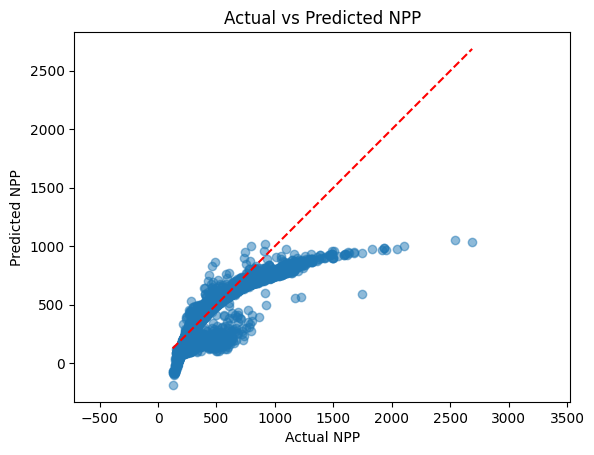

In [ ]:
# 5. Visualize Actual vs Predicted

import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # ideal line
plt.xlabel("Actual NPP")
plt.ylabel("Predicted NPP")
plt.title("Actual vs Predicted NPP")
plt.axis('equal')  # <-- ensures same scaling
plt.show()



Explaination:

Points near the red line = good predictions.

Points below the line = model underpredicted NPP.

Points above the line = model overpredicted NPP.

Saturation effect: Predictions start to flatten near 1000, even as actual NPP continues increasing.

This may indicate the model is not capturing high-NPP behavior well (e.g., it's biased toward the mean or lacks nonlinear expressiveness).



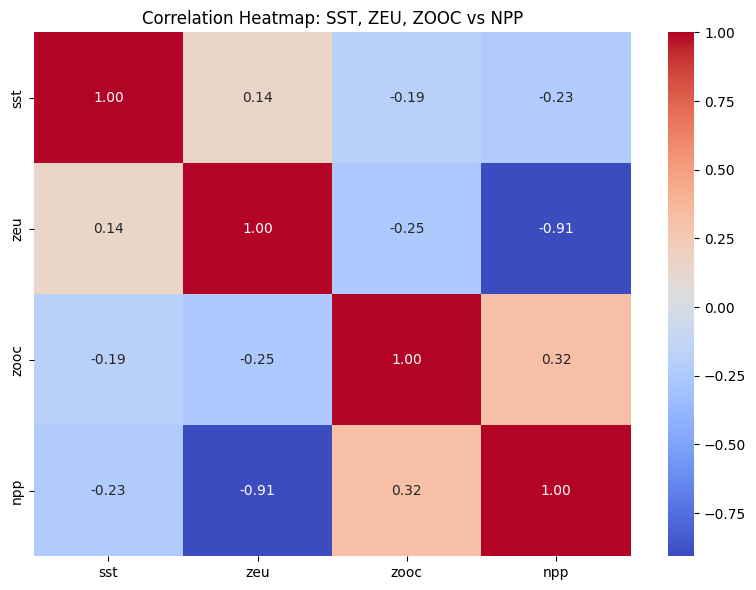

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a correlation heatmap between features and target
plt.figure(figsize=(8, 6))
sns.heatmap(merged_df[['sst', 'zeu', 'zooc', 'npp']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: SST, ZEU, ZOOC vs NPP")
plt.tight_layout()
plt.show()


### Key Observations:

---

**1. Strong Negative Correlation Between ZEU and NPP (−0.91)**  
→ This suggests that when euphotic depth (ZEU) increases (i.e., light penetrates deeper), surface productivity (NPP) tends to decrease.

*Justification:*  
- High ZEU often means clearer, nutrient-poor waters → less phytoplankton growth (lower NPP).  
- In tropical regions like Barbados, sunlight is abundant year-round, so **light isn’t the limiting factor**.  
- **Nutrient availability** (e.g., nitrogen, phosphorus from deep water) becomes the main driver of productivity.  

So:  
- More light (deeper ZEU) ≠ more productivity  
- More nutrients → more productivity  
- Hence, negative correlation between ZEU and NPP

---

**2. Positive Correlation Between ZOOC and NPP (+0.32)**  
→ Where there's more primary productivity (NPP), there’s generally more zooplankton feeding on it.

*Supports the trophic link:*  
- Higher NPP → more food for zooplankton → higher zooplankton biomass

---

**3. Weak Negative Correlation Between SST and NPP (−0.23)**  
→ Warmer sea surface temperatures slightly reduce productivity.

*Matches established findings:*  
- Warmer waters = less nutrient mixing → reduced phytoplankton growth  
- Especially relevant in stratified tropical waters like the Caribbean

📄 Reference: [Nature article on SST and productivity](https://www.nature.com/articles/s41598-018-20560-5#:~:text=In%20the%20tropics%2C%20thermal%20stratification,layer%2C%20ultimately%20limiting%20phytoplankton%20growth.)

---
